In [1]:
import sys
import torch
import ot

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../lib")
from distributions import sampleWrappedNormal
from utils_hyperbolic import *
from hsw import hyper_sliced_wasserstein
from hhsw import horo_hyper_sliced_wasserstein_lorentz, horo_hyper_sliced_wasserstein_poincare
from sw import sliced_wasserstein
from utility import *
import time
from tqdm.auto import trange
import base



device = "cuda" if torch.cuda.is_available() else "cpu"

## Lorentz Model

In [8]:
ds = [3]
mu_ = torch.zeros(ds[0])
mu_[0] = 1

mu0 = torch.tensor(mu_, dtype=torch.float, device=device)
Sigma0 = torch.eye(ds[0]-1, dtype=torch.float, device=device)


ntry = 10
pbar = True
samples = [int(1e2),int(1e3),int(1e4),int(1e5/2),int(1e5)] #,int(1e6/2)]
n_projs = 500

/tmp/ipykernel_3142295/199681369.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu0 = torch.tensor(mu_, dtype=torch.float, device=device)


In [2]:
L_hsw = np.zeros((len(ds), len(samples), ntry))
L_hhsw = np.zeros((len(ds), len(samples), ntry))
L_sw = np.zeros((len(ds), len(samples), ntry))
L_w = np.zeros((len(ds), len(samples), ntry))
L_sfw = np.zeros((len(ds), len(samples), ntry))


gen = torch.Generator(device=device)
gen.manual_seed(42)


for i, d in enumerate(ds):
    for k, n_samples in enumerate(samples):
        x0 = sampleWrappedNormal(mu0, Sigma0, n_samples)
        x1 = sampleWrappedNormal(mu0, Sigma0, n_samples)
        
        if pbar:
            bar = trange(ntry)
        else:
            bar = range(ntry)

        for j in bar:

            ## SFW
            try:
                torch.cuda.synchronize()
                t0 = time.time()
                sfw = SFW(x0, x1, hyperbolic_model="Lorentz", spf_curve="Mm_l")
                torch.cuda.synchronize()
                L_sfw[i,k,j] = time.time()-t0
            except:
                L_sfw[i,k,j] = np.inf

            ## HSW
            try:
                torch.cuda.synchronize()
                t0 = time.time()
                hsw = hyper_sliced_wasserstein(x0, x1, n_projs, device, p=2)
                torch.cuda.synchronize()
                L_hsw[i, k, j] = time.time()-t0
            except:
                L_hsw[i,k,j] = np.inf

            ## HHSW
            try:
                torch.cuda.synchronize()
                t0 = time.time()
                hhsw = horo_hyper_sliced_wasserstein_lorentz(x0, x1, n_projs, device, p=2)
                torch.cuda.synchronize()
                L_hhsw[i,k,j] = time.time()-t0
            except:
                L_hhsw[i,k,j] = np.inf

            ## SW
            try:
                torch.cuda.synchronize()
                t0 = time.time()
                swl = ot.sliced_wasserstein_distance(x0, x1, n_projections=n_projs, seed=gen)
                # swl = sliced_wasserstein(x0, x1, n_projs, device, p=2)
                torch.cuda.synchronize()
                L_sw[i, k, j] = time.time()-t0
            except:
                L_sw[i,k,j] = np.inf


            if n_samples<20000:
                # ## Sinkhorn
                # try:
                #     t2 = time.time()

                #     a = torch.ones((n_samples,), device=device)/n_samples
                #     b = torch.ones((n_samples,), device=device)/n_samples
                #     M = torch.arccosh(torch.clamp(-minkowski_ip2(x0, x1), min=1+1e-5))**2
                #     w = ot.sinkhorn2(a, b, M, reg=0.1, numitermax=10000, stopThr=1e-15)

                #     L_s[i,k,j] = time.time()-t2
                # except:
                #     L_s[i,k,j] = np.inf
                
                ## EMD
                try:
                    torch.cuda.synchronize()
                    t1 = time.time()

                    a = torch.ones((n_samples,), device=device)/n_samples
                    b = torch.ones((n_samples,), device=device)/n_samples
                    M = torch.arccosh(torch.clamp(-minkowski_ip2(x0, x1), min=1+1e-5))**2
                    w = ot.emd2(a, b, M)
                    torch.cuda.synchronize()
                    L_w[i,k,j] = time.time()-t1
                except:
                    L_w[i,k,j] = np.inf


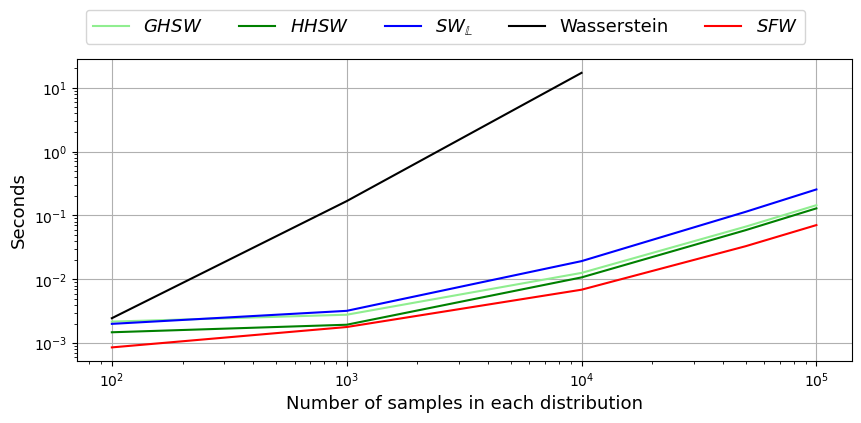

In [10]:
fig = plt.figure(figsize=(10,4), dpi=100)


ds = [3]
samples = [int(1e2),int(1e3),int(1e4),int(1e5/2),int(1e5)]


for i, d in enumerate(ds):
    m = np.mean(L_hsw[i], axis=-1)        
    plt.loglog(samples, m, label=r"$GHSW$", c="lightgreen")
    
    m = np.mean(L_hhsw[i], axis=-1)    
    plt.loglog(samples, m, label=r"$HHSW$", c="g")
    
    m = np.mean(L_sw[i], axis=-1)
    plt.loglog(samples, m, label=r"$SW_\mathbb{L}$",c="b")
        
    m_w = np.mean(L_w[i], axis=-1)
    plt.loglog(samples[:3], m_w[:3], label=r"Wasserstein",c="k")


    m_sfw = np.mean(L_sfw[i], axis=-1)
    plt.loglog(samples, m_sfw, label=r"$SFW$",c="r")



plt.xlabel(r"Number of samples in each distribution", fontsize=13)
plt.ylabel(r"Seconds", fontsize=13)

    
plt.legend(fontsize=13, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", ncol=5)
plt.grid(True)
plt.yticks([10,1,0.1,0.01,0.001])
# plt.savefig("../results/time.pdf", format="pdf", bbox_inches="tight")
plt.show()